# Analyse modularity with R&B parameter
---

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks

import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities

from tqdm.notebook import tqdm

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


## Finding Communities
---

In [ ]:
%%time
# Obtain modularity communities
resolution = 1
modularity_communities = [list(greedy_modularity_communities(g,weight='weight',resolution = resolution)) for g in networks]
for comm in modularity_communities:
    print(f"{len(comm)} communities: {[len(x) for x in comm]}")

In [ ]:
#Modularity scores:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,modularity_communities)]
print(modularity_scores)

partition_quality = [nx_comm.partition_quality(g,comm) for g,comm in zip(networks,modularity_communities)]
print(partition_quality)

## Test resolution parameter

In [33]:
# Obtain modularity communities
def get_modullarity_communities(G:nx.Graph,resolution=1):
    modularity_communities = list(greedy_modularity_communities(g,weight='weight',resolution = r))
    return(modularity_communities)

In [180]:
%%time
# resolutions = np.arange(0,1,0.1)
# resolutions = np.append(resolutions,np.arange(1,20.5,0.5))
# resolutions = np.append(resolutions,np.arange(20,50,1))
# resolutions = np.append(resolutions,np.arange(50,1020,25))
resolutions = [0.6]

print(resolutions)
for r in tqdm(resolutions):
    for g,year in zip(networks,range(2018,2022)):
        communities_by_resolution[year][r] = [list(y) for y in get_modullarity_communities(g,resolution=resolutions)]

[0.6]


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 33.8 s, sys: 13.2 ms, total: 33.8 s
Wall time: 33.9 s


In [206]:
#Classify Communities
communities_statistics = {}
for (year,comms),g in  zip(communities_by_resolution.items(),networks):
    communities_statistics[year] = {"N_communities":    [(r,len(x)) for r,x in comms.items()],
                                    "Avg_comm_size":    [np.average([len(y) for y in x]) for x in comms.values()],
                                    "Sigma_comm_size":  [np.std([len(y) for y in x]) for x in comms.values()],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms.values()]}#,
                                    # "Modularity_score": [nx_comm.modularity(g,c,resolution=r, weight='weight') for r,c in list(comms.items())]}

In [ ]:
[len(x) for r,x in list(communities_by_resolution[2021].items())]

In [208]:
# Export Data
import json
for year in range(2018,2022):
    keys = [float(x) for x in communities_by_resolution[year].keys()]
    communities_by_resolution[year] = dict(zip(keys, communities_by_resolution[year].values()))
with open("data/modularity_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)
with open("data/modularity_communities_statistics.json", "w") as f:
    json.dump(communities_statistics,f)

## Visualize Data
---

In [79]:
#Import data
import json
def keystoint(x):
    return {int(k): v for k, v in x.items()}
with open("data/modularity_communities_statistics.json", "r") as f:
    communities_statistics = json.load(f)
with open("data/modularity_communities.json", "r") as f:
    communities_by_resolution = json.load(f, object_hook=keystoint)
    

resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))

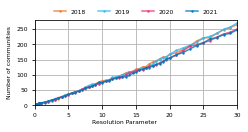

In [148]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8.7*cm,0.5*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax.set(ylabel="Number of communities",xscale="linear",yscale="linear",xlim=(0,30),ylim=(0,280))
for year, data in communities_statistics.items():
    x = list(communities_by_resolution[int(year)].keys())
    y = data["N_communities"]
    
    x = [x for x,y in data["N_communities"] if x<=30]
    y = [y for x,y in data["N_communities"] if x<=30]
    
    
    ax.plot(x,y,label=year, marker='o',ls="-", ms=1.5,alpha=0.8, color = colors[int(year)])
    
ax.grid()
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/modularity_community_N.pdf")
# plt.savefig("modularity_community_statistics.png",dpi=200)

In [150]:
from scipy.stats import linregress

fits = []
for year, data in communities_statistics.items():
    x = [x for x,y in data["N_communities"] if x<=30]
    y = [y for x,y in data["N_communities"] if x<=30]
    
    fits.append(linregress(list(zip(x,y))))
    # print(fits[-1])
    print(f"\\SI{{{fits[-1].slope:.3f}({fits[-1].stderr:.4f})}}{{}} & \\SI{{{fits[-1].intercept:.3f}({fits[-1].intercept_stderr:.4f})}}{{}} & {fits[-1].rvalue:.4f}\\\\")#, str(fits[-1].intercept),str(fits[-1].pvalue)]))

\SI{8.671(0.0828)}{} & \SI{-6.204(1.1874)}{} & 0.9974\\
\SI{8.668(0.0994)}{} & \SI{-6.202(1.4250)}{} & 0.9963\\
\SI{8.132(0.0811)}{} & \SI{-4.308(1.1629)}{} & 0.9972\\
\SI{8.070(0.0829)}{} & \SI{-4.470(1.1880)}{} & 0.9970\\


{2018: 7604.0, 2019: 19500.0, 2020: 4439.0, 2021: 3171.0}


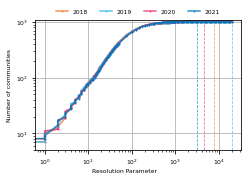

In [149]:
#ASYMPTOTIC 
rmax = {}
for g,year in zip(networks,range(2018,2022)):
    rmax[year] = min([n for n,x in communities_by_resolution[year].items() if len(x)==g.number_of_nodes()])
pos = dict(zip(range(2018,2022),[5,12,105,250]))
print(rmax)

colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8.7*cm,0.7*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax.set(ylabel="Number of communities",xscale="log",yscale="log",ylim=(5,1.1e3))
# for year, data in communities_statisticsj.items():
for year in range(2018,2022):
    n_comms = [len(y) for x,y in communities_by_resolution[year].items()]
    resolutions = [int(x) for x,y in communities_by_resolution[year].items()]
    
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))
    
    ax.plot(resolutions,n_comms,marker="o",ls="-",markersize=1, label=year, c=colors[year],alpha=0.8)
    ax.axvline(rmax[year],ls="--",lw=0.8,c=colors[year],alpha=0.7)
    # ax.text(rmax[year],pos[year],year,ha="right")
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))
    
             

ax.grid()
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/modularity_community_asymptotic.pdf")


In [56]:
#RMAX
W = {}
for year, g in zip(range(2018,2022),networks):
    W[year] = sum([edge[2]["weight"] for edge in g.edges(data=True)])
    
ws = dict(zip(range(2018,2022),[[],[],[],[]]))
for year, g in zip(range(2018,2022),networks):
    for x in g.nodes():
        for y in g.nodes():
            if x != y:
                n = g.number_of_nodes()
                try:
                    wij = g.edges[x,y]['weight']
                except:
                    continue
                wi  = nx.degree(g,x,weight="weight") 
                wj  = nx.degree(g,y,weight="weight") 
                ws[year].append(((x,y,wi,wj,wij), 2 * W[year] * wij/(wi*wj)))
                

In [59]:
print(W)
for year in range(2018,2022):
    print(max(ws[year], key = lambda x: x[1]))

{2018: 506771, 2019: 506703, 2020: 644401, 2021: 660132}
(('1307_A011', '1307_A010', 30, 9, 2), 7507.718518518518)
(('3062_L163', '3131_9878', 5, 21, 2), 19302.97142857143)
(('3141_L169', '3141_8419', 62, 5, 1), 4157.4258064516125)
(('3152_9123', '3154_9090', 215, 2, 1), 3070.381395348837)


In [ ]:
from scipy.stats import norm

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set(xlabel="Community size", ylabel="p")

x = np.linspace(0,150,200)
for average,std in zip(communities_statistics[2018]["Avg_comm_size"],communities_statistics[2018]["Sigma_comm_size"]):
    ax.plot(x,norm(loc=average,scale=std).pdf(x),label=year, marker='',ls='-', ms=3)
             
ax.grid()
# ax.legend()

In [63]:
# Find matching communities
def enumerate_simmilarity(enum, min_courses, max_courses):
    scores = []
    simmilarity = lambda x, y: len(set(x) & set(y))**2 /(1 + len(set(x) - set(y)) + len(set(y) - set(x)))
    for comm1 in min_courses:
        scores.append([simmilarity(comm1,comm2) for comm2 in max_courses])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(min_courses),-1)
        
    for i in range(len(min_courses)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1e6
        scores[:,index[1]] = -1e6
     
    return list(zip(best,enum))

[(0, {'Ciências da Vida': 6, 'Ciências Exatas': 14, 'Educação': 26, 'Humanidades': 82, 'Ciências Empresariais': 156, 'Artes e Arquitetura': 99, 'Direito, Ciências Sociais e do Comportamento': 98, 'Serviços Sociais e Pessoais': 93}), (1, {'Ciências da Vida': 83, 'Ciências Exatas': 237, 'Educação': 1, 'Ciências Empresariais': 2, 'Artes e Arquitetura': 2, 'Saúde': 102})]
574
427


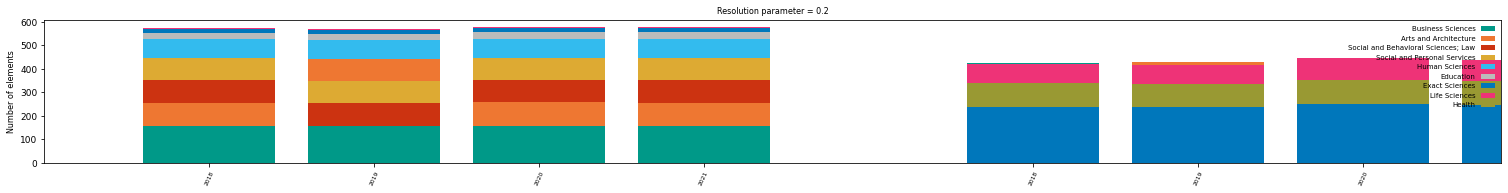

In [8]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = 1
areas_in_comm = {}
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]
    
max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

max_comms = communities_by_resolution[str(max_idx)][resolution_index]

for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
    if year == max_idx: 
        areas_in_comm[year] = max_comms_enum
        continue
    areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

print(areas_in_comm[2018])
print(sum(areas_in_comm[2018][0][1].values()))
print(sum(areas_in_comm[2018][1][1].values()))

TypeError: enumerate_simmilarity() missing 1 required positional argument: 'max_courses'

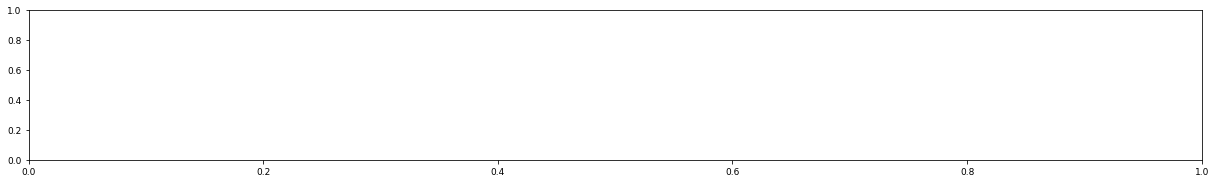

In [12]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = -1
areas_in_comm = []
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

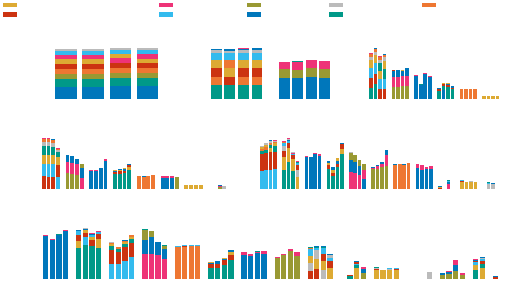

In [209]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})

github = False
if github:
    COLOR = 'white'
    plt.rcParams.update({'text.color': COLOR})
    plt.rcParams.update({'axes.labelcolor': COLOR}) 
    plt.rcParams.update({'xtick.color': COLOR}) 
    plt.rcParams.update({'ytick.color': COLOR}) 
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)


x0 = 0

cm = 1/2.54
# fig,axes = plt.subplots(nrows=5, figsize=(17.8*cm,5*4*cm))

mosaic = """
EEEAAABBB
CCCCFFFFF
DDDDDDDDD
"""
fig = plt.figure(constrained_layout=False, figsize=(17.8*cm,3*3.5*cm))
ax_dict = fig.subplot_mosaic(mosaic)

# resolution_index = 9
for ax,resolution_index in zip(ax_dict.values(),[0,0.2,0.6,1,1.5,2]):
    areas_in_comm = {}
    for G in networks:
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[G.graph["year"]][resolution_index]]
        areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]


    max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
    max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

    max_comms = communities_by_resolution[max_idx][resolution_index]
    
    for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
        if year == max_idx: 
            areas_in_comm[year] = max_comms_enum
            continue
        areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    years = list(range(18,22))*len(max_comms)
    idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
    idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        

    ax.set_xticks(idx_minor,minor=True)
    ax.set_xticks(idx,minor=False)
    ax.tick_params(which="minor",axis="x",direction="in")
    ax.set_xticklabels(years, rotation=70, fontdict={"fontsize":6})

    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_title(f"Resolution parameter = {resolution_index:.1f}", fontdict={"fontsize":8})

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = zip(*sorted(list(zip(handles,labels)),key=lambda x: x[1],reverse = True))
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
if not github:
    plt.savefig("images/modularity_communities_by_field.png")
else:
    plt.savefig("images/modularity_communities_by_field_gh.svg",orientation='landscape', transparent=True)

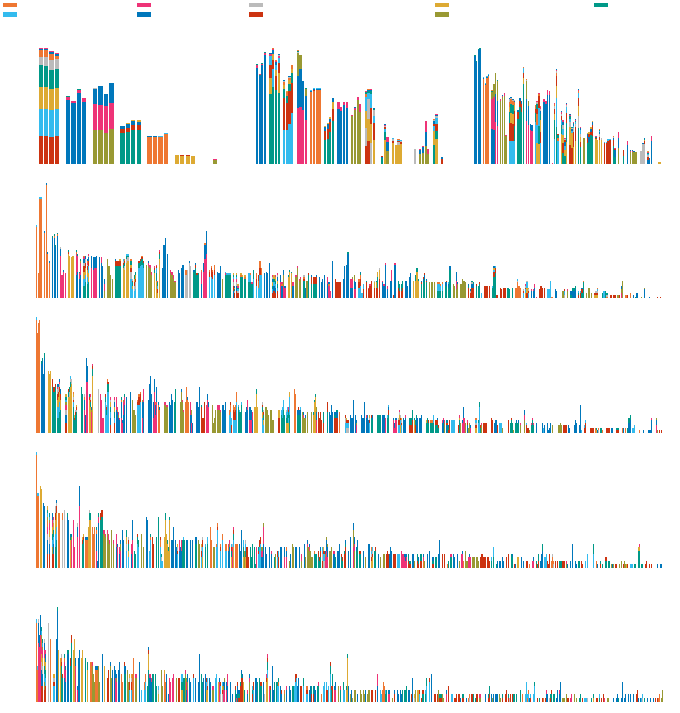

In [203]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))


plt.rcParams.update({'font.size': 9})

github = False
if github:
    COLOR = 'white'
    plt.rcParams.update({'text.color': COLOR})
    plt.rcParams.update({'axes.labelcolor': COLOR}) 
    plt.rcParams.update({'xtick.color': COLOR}) 
    plt.rcParams.update({'ytick.color': COLOR}) 
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)


x0 = 0


mosaic = """
ABC
DDD
EEE
FFF
GGG
"""
cm = 1/2.54
fig = plt.figure(constrained_layout=False, figsize=(23.5*cm,25*cm))
ax_dict = fig.subplot_mosaic(mosaic)

for ax,resolution_index in zip(ax_dict.values(),[0.8,2,3,10,15,20,25]):
    areas_in_comm = {}
    for n, G in enumerate(networks):
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[G.graph["year"]][resolution_index]]
        areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]
        
    max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
    max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

    max_comms = communities_by_resolution[max_idx][resolution_index]

    for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
        if year == max_idx: 
            areas_in_comm[year] = max_comms_enum
            continue
        areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    if resolution_index < 10:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks(idx_minor,minor=True)
        ax.set_xticks(idx,minor=False)
        ax.tick_params(which="minor",axis="x",direction="in")
        ax.set_xticklabels([""]*len(idx), rotation=65, fontdict={"fontsize":6})
    else:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks([],minor=False)
        ax.set_xticklabels([], rotation=65, fontdict={"fontsize":6})


    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.text(0.5,1,f"Resolution parameter = {resolution_index:.1f}", fontsize=8,transform=ax.transAxes,va="top",ha="center")

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
if not github:
    plt.savefig("images/modularity_communities_by_field_extra.png")
else:
    plt.savefig("images/modularity_communities_by_field_extra_gh.svg",orientation='landscape', transparent=True)
# plt.savefig("comm.jpeg",dpi=200)
